***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Intro Vorlesung 5: Syntaktische Funktionen (Dependenzanalyse)

In [1]:
import nltk

In [2]:
import spacy
from spacy import displacy
nlp = spacy.load('de_core_news_sm')

In [3]:
def transform_nr_conll(sent_nr):
    sent_list = []
    for line in list(filter(None, sent_nr.split("\n"))):
        line_list = line.split()
        line_list.pop(0)
        line_list.insert(1,"_")
        sent_list.append(" ".join([i for i in line_list[0:]]))

    return "\n".join([i for i in sent_list[0:]])

In [4]:
from nltk import DependencyGraph
from nltk.tree import Tree
from itertools import chain


### tree_labeled-Methode für DependencyGraphs (pretty_print-Dependenzbäume mit Labels):
def _tree_labeled(self, i):
        node = self.get_by_address(i)
        word = node["word"]
        rel = node["rel"]        
        deps = sorted(chain.from_iterable(node["deps"].values()))

        if deps:
            return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])
        else:
            return word+'('+rel+')'
        
def tree_labeled(self):
        node = self.root

        word = node["word"]
        rel = node["rel"]
        deps = sorted(chain.from_iterable(node["deps"].values()))
        return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])

    
DependencyGraph._tree_labeled = _tree_labeled
DependencyGraph.tree_labeled = tree_labeled

In [5]:
#Konvertierungsfunktion von conll(4)-Format (MALT-tabular) für Rendering mit displaCy:
def displacy_dep_input(sent):
    deps = []
    for dep in sent.split('\n'):
        deps.append(dep.split())

    deps = [x for x in deps if x]

    ex = []
    word_list = []
    arc_list = []

    for index, dep in enumerate(deps):
        word_list.append({"text": dep[0], "tag": ""})
        line = index+1
        head = int(dep[2])
        label = dep[3]
        if head>line:
            start = index
            end = head-1
            direction = "left"
        else:
            start = head-1
            end = index  
            direction = "right"
        if(label.lower() != "root"):
            arc_list.append({"start": start, "end": end, "label": label, "dir": direction})

    ex.append({
        "words": word_list,
        "arcs": arc_list
    })    

    return ex

## 1. vom Eliminierungstest zu Dependenzrelationen

In [6]:
# Dependenzanalyse
sent_nr = """
1 die 4 det
2 sehr 3 advmod
3 große 4 amod
4 Katze 0 ROOT
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

         Katze(ROOT)             
   ┌──────────┴───────────┐       
   │                 große(amod) 
   │                      │       
die(det)             sehr(advmod)



In [7]:
ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

---

### Definition Dependenz
> ***Dependenz: strukturelle Beziehung zwischen zwei Konstituenten, die auf
Abhängigkeit beruht: Eine Konstituente D hängt von einer Konstituente H ab,
wenn D ohne H nicht stehen kann.*** (vgl. Dürscheid, Glossar)

#### schrittweise 1-Wort-Eliminierungen:
`* = ungrammatisch`

```
die sehr große Katze
    ↓
sehr große Katze  (4) 
die große Katze
*die sehr Katze  
*die sehr große
    ↓
große Katze       (4, 3)          
die Katze         (2)
*sehr Katze       (4)
*sehr große
*die große
    ↓          
Katze             (1)
*große            (3)
*die              (2)
                
```


### Dependenzregeln: `H -> D`
#### D (dependent) kann nicht ohne H (head) stehen:

```
1. ROOT -> Katze
2. Katze (H) -> die (D)
3. Katze (H) -> große (D) 
4. große (H) -> sehr (D)
```


In [8]:
# Grammatik als Ergebnis der Eliminierungstests:
grammar = nltk.DependencyGrammar.fromstring("""
    'ROOT' -> 'Katze'
    'Katze' -> 'die' | 'große'
    'große' -> 'sehr'
""")

parser = nltk.ProjectiveDependencyParser(grammar)

In [9]:
sent = 'ROOT die sehr große Katze'.split()
for tree in parser.parse(sent):
    tree.pretty_print(unicodelines=True)

     ROOT      
      │         
    Katze      
 ┌────┴─────┐   
 │        große
 │          │   
die        sehr



In [10]:
#nicht wohlgeformt:
sent = 'ROOT die sehr Katze'.split()
for tree in parser.parse(sent):
    tree.pretty_print(unicodelines=True)
    #kein Parse (kein Kopf für 'sehr')

In [11]:
#nicht wohlgeformt:
sent = 'ROOT sehr große'.split()
for tree in parser.parse(sent):
    tree.pretty_print(unicodelines=True)
    #kein Parse (kein ROOT-Knoten)

In [12]:
sent = 'ROOT große Katze'.split()
for tree in parser.parse(sent):
    tree.pretty_print(unicodelines=True)

 ROOT
  │   
Katze
  │   
große



---
## 2. Dependency Tagsets


#### **UD: https://universaldependencies.org/u/dep/ **
#### **TIGER: https://www.linguistik.hu-berlin.de/de/institut/professuren/korpuslinguistik/mitarbeiter-innen/hagen/DDB_edge**
  - für Beispiele s. auch http://www.coli.uni-saarland.de/projects/sfb378/negra-corpus/kanten.html#MO

---
 
## 3. Syntaktische Funktionen in einfachen Sätzen (*clauses*):

*(für Syntaktische Funktionen komplexer Sätze: siehe Sitzung 8)*

#### *Verb als Satzzentrum:*
  - **Prädikat: `ROOT`**
      
    
#### *Syntaktische Funktionen von (valenzgeforderten) Verb-KOMPLEMENTEN:*
  - **Subjekt: `nsubj`** (**UD**),  **`sb`**(**TIGER**)
  - **Objekt:**
    - **direktes Objekt**: **`obj`** (**UD**), **`oa`** (**TIGER**)
    - **indirektes Objekt**: **`iobj`** (**UD**),**`da`** (**TIGER**)
    - ***Präpositionalobjekt***: in UD als Adverbial **`obl`**, dagegen in TIGER als **`op`** ('Objekt, präpositional'), z.B. *an etwas glauben*
  - ***adverbiales Komplement: `obl` (UD), `mo` (TIGER)***, z.B. *auf/neben den Tisch stellen*


#### *Syntaktische Funktion von ADJUNKTEN des Verbs:*

  - **Adverbial** (verbale Modifikatoren: Form und Auftreten unabhängig von Kopf): 
    - **nominales Adverbial: `obl`** (**UD**), **`mo`** (**TIGER**)
        - auch: ***Kasusadverbial***, z.B. *läuft den ganzen Tag*, *kommt eines Tages*
    - **adverbieller Modifikator**: **`advmod`** (**UD**), **`mo`** (**TIGER**)


#### *Syntaktische Funktionen von ADJUNKTEN (und KOMPLEMENTEN) des Nomens:*
  - **Attribut** (Modifikator oder auch Komplement des Nomens):
      - **nominaler Modfikator**: **`nmod`** (**UD**), **`nk`** (**TIGER**)
      - **Determinierer**: **`det`** (**UD**), **`nk`** (**TIGER**)
      - **Adjektiv-Attribut**: **`amod`** (**UD**), **`nk`** (**TIGER**)
      - **Genitiv-Attribut**: **`nmod`** (**UD**), **`ag`** (**TIGER**)
   

---
## 4. Dependenzgrammatik: Transitiver Beispielsatz

In [13]:
grammar = nltk.DependencyGrammar.fromstring("""
    'jagt' -> 'Hund' | 'Briefträger'
    'Hund' ->  'der' | 'den' | 'langsamen'
    'Briefträger' -> 'der' |'den' | 'langsamen'
    """)

parser = nltk.ProjectiveDependencyParser(grammar)

In [14]:
sent = 'der Hund jagt den langsamen Briefträger'.split()

for tree in parser.parse(sent):
    print(tree, "\n")
    tree.pretty_print(unicodelines=True)

(jagt (Hund der) (Briefträger den langsamen)) 

     jagt                      
 ┌────┴────────┐                
Hund      Briefträger          
 │    ┌────────┴──────────┐     
der  den              langsamen



--- 

## 5. Dependenzbäume zeichnen

- **https://www.nltk.org/_modules/nltk/parse/dependencygraph.html**
- **http://stp.lingfil.uu.se/~nivre/research/MaltXML.html**
- **(CoNLL(10) or Malt-Tab(4) format)**



- **0 = ROOT-Knoten**
- **Kennzeichung des Kopfs eines Dependenten über Zeilenangabe**

In [15]:
#NLTK-Standard-Format (ohne Index/Token-Position):

In [16]:
sent = """John N 2
loves V 0
Mary N 2
"""

dg = DependencyGraph(sent)
tree = dg.tree()

print(tree)
tree.pretty_print(unicodelines=True)  

(loves John Mary)
     loves     
 ┌─────┴────┐   
John       Mary



In [17]:
#Kurs-Format mit Index/Token-Position:
# (Verwendung von transform_nr_conll())
 
#### INDEX TOKEN HEAD RELATION

sent_nr = """
1 John 2 nsubj
2 loves 0 ROOT
3 Mary 2 obj
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

            loves(ROOT)          
     ┌───────────┴──────────┐     
John(nsubj)             Mary(obj)



In [18]:
#Darstellung mit displacy:

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

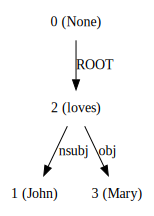

In [19]:
#Darstellung mit tk:
display(dg)

In [20]:
# Darstellung als Tripel:
list(dg.triples())

[(('loves', '_'), 'nsubj', ('John', '_')),
 (('loves', '_'), 'obj', ('Mary', '_'))]

In [21]:
#Transformation in Conll-Format:
print(dg.to_conll(10))

1	John	John	_	_		2	nsubj	_	_
2	loves	loves	_	_		0	ROOT	_	_
3	Mary	Mary	_	_		2	obj	_	_



--- 

## Analyse transitiver Satz  (`nsubj`; `sb` sowie  `obj`; `oa`)

In [22]:
#UD-Analyse:
sent_nr = """
1 der 2 det  
2 Hund 3 nsbuj
3 jagt 0 ROOT
4 den 6 det
5 langsamen 6 amod 
6 Briefträger 3 obj
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

            jagt(ROOT)                                 
     ┌──────────┴─────────────┐                         
Hund(nsbuj)            Briefträger(obj)                
     │          ┌─────────────┴────────────────┐        
  der(det)   den(det)                   langsamen(amod)



In [23]:
print(spacy.explain('nsubj'), spacy.explain('obj'), spacy.explain('det'), spacy.explain('amod'), sep="\n")

nominal subject
object
determiner
adjectival modifier


In [24]:
#TIGER-Analyse:
sent_nr = """
1 der 2 nk  
2 Hund 3 sb
3 jagt 0 ROOT
4 den 6 nk
5 langsamen 6 nk 
6 Briefträger 3 oa
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

         jagt(ROOT)                              
   ┌─────────┴─────────────┐                      
Hund(sb)            Briefträger(oa)              
   │         ┌─────────────┴──────────────┐       
der(nk)   den(nk)                   langsamen(nk)



In [25]:
print(spacy.explain('sb'), spacy.explain('oa'), spacy.explain('nk'), sep="\n")

subject
accusative object
noun kernel element


---
## Analyse indirektes Objekt (`iobj`; `da`)

In [26]:
#UD-Analyse:
sent_nr = """
1 der 2 det  
2 Briefträger 3 nsubj
3 übergibt 0 ROOT
4 der 5 det
5 Stadt 3 iobj
6 den 7 det
7 Hund 3 obj
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

             übergibt(ROOT)          
     ┌─────────────┼────────────┐     
Briefträger(  Stadt(iobj)   Hund(obj)
   nsubj)          │            │    
     │             │            │     
  der(det)      der(det)     den(det)



In [27]:
print(spacy.explain('obj'), spacy.explain('iobj'), sep="\n")

object
indirect object


In [28]:
#TIGER-Analyse:
sent_nr = """
1 der 2 nk  
2 Briefträger 3 sb
3 übergibt 0 ROOT
4 der 5 nk
5 Stadt 3 da
6 den 7 nk
7 Hund 3 oa
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

                übergibt(ROOT)         
       ┌──────────────┼───────────┐     
Briefträger(sb)   Stadt(da)    Hund(oa)
       │              │           │     
    der(nk)        der(nk)     den(nk) 



In [29]:
print(spacy.explain('da'),spacy.explain('oa'), sep="\n")

dative
accusative object


---

## Analyse nominaler Attribute

---

### Genitiv-Attribut (`nmod`; `ag`)

In [30]:
#UD-Analyse:
sent_nr = """
1 der 2 det  
2 Hund 3 nsubj
3 jagt 0 ROOT
4 den 5 det
5 Briefträger 3 obj
6 der 7 det
7 Stadt 5 nmod
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

            jagt(ROOT)                             
     ┌──────────┴─────────────┐                     
     │                 Briefträger(obj)            
     │          ┌─────────────┴──────────────┐      
Hund(nsubj)     │                       Stadt(nmod)
     │          │                            │      
  der(det)   den(det)                     der(det) 



In [31]:
print(spacy.explain('nmod'), sep="\n")

modifier of nominal


In [32]:
#TIGER-Analyse:
sent_nr = """
1 der 2 nk  
2 Hund 3 sb
3 jagt 0 ROOT
4 den 5 nk
5 Briefträger 3 oa
6 der 7 nk
7 Stadt 5 ag 
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

         jagt(ROOT)                          
   ┌─────────┴─────────────┐                  
   │                Briefträger(oa)          
   │         ┌─────────────┴────────────┐     
Hund(sb)     │                      Stadt(ag)
   │         │                          │     
der(nk)   den(nk)                    der(nk) 



In [33]:
print(spacy.explain('ag'), sep="\n")

genitive attribute


---

### Präpositional-Attribut (`nmod`; `mnr`)

##### Beachte *primacy-of-content-words*-Maxime bei UD gegenüber TIGER!

In [34]:
#UD-Analyse (N als KOPF der PP = primacy of content words):
sent_nr = """
1 der 2 det  
2 Hund 3 nsubj
3 jagt 0 ROOT
4 den 5 det
5 Briefträger 3 obj
6 aus 7 case
7 München 5 nmod
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

            jagt(ROOT)                               
     ┌──────────┴─────────────┐                       
     │                 Briefträger(obj)              
     │          ┌─────────────┴───────────────┐       
Hund(nsubj)     │                       München(nmod)
     │          │                             │       
  der(det)   den(det)                     aus(case)  



In [35]:
print(spacy.explain('nmod'), spacy.explain('case'), sep="\n")

modifier of nominal
case marking


In [36]:
#TIGER-Analyse (P als Kopf der PP):
sent_nr = """
1 der 2 nk  
2 Hund 3 sb
3 mag 0 ROOT
4 den 5 nk
5 Briefträger 3 oa
6 aus 5 mnr
7 München 6 nk 
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

         mag(ROOT)                            
   ┌─────────┴────────────┐                    
   │               Briefträger(oa)            
   │         ┌────────────┴─────────────┐      
Hund(sb)     │                       aus(mnr) 
   │         │                          │      
der(nk)   den(nk)                  München(nk)



In [37]:
print(spacy.explain('mnr'), spacy.explain('nk'), sep="\n")

postnominal modifier
noun kernel element


---


## Analyse Adverbial

### Präpositional-Adverbial  (`obl`; `mo`)


In [38]:
#UD-Analyse:
sent_nr = """
1 der 2 det  
2 Hund 3 nsubj
3 jagt 0 ROOT
4 den 5 det
5 Briefträger 3 obj
6 aus 7 case
7 München 3 obl
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

               jagt(ROOT)                
     ┌─────────────┼──────────────┐       
Hund(nsubj) Briefträger(obj) München(obl)
     │             │              │       
  der(det)      den(det)      aus(case)  



In [39]:
print(spacy.explain('obl'), spacy.explain('case'), sep="\n")

oblique nominal
case marking


In [40]:
#TIGER-Analyse:
sent_nr = """
1 der 2 nk  
2 Hund 3 sb
3 jagt 0 ROOT
4 den 5 nk
5 Briefträger 3 oa
6 aus 3 mo
7 München 6 nk 
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

            jagt(ROOT)              
   ┌────────────┼─────────────┐      
Hund(sb) Briefträger(oa)   aus(mo)  
   │            │             │      
der(nk)      den(nk)     München(nk)



In [41]:
print(spacy.explain('mo'), spacy.explain('nk'), sep="\n")

modifier
noun kernel element


---
### Kasusadverbial (`obl`; `mo`)

- **Kasusmarkierung kann auch adverbiale Funktion anzeigen: *Er läuft den ganzen Tag.* **
- **weder Auftreten noch Form valenzgefordert (Adjunkt)**

In [42]:
#UD-Analyse:
sent_nr = """
1 der 2 det  
2 Briefträger 3 nsubj
3 verschwand 0 ROOT
4 dieser 5 det
5 Tage 3 obl
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

             verschwand(ROOT)            
     ┌──────────────┴──────────────┐      
Briefträger(                   Tage(obl) 
   nsubj)                          │     
     │                             │      
  der(det)                    dieser(det)



In [43]:
print(spacy.explain('obl'), sep="\n")

oblique nominal


In [44]:
#TIGER-Analyse:
sent_nr = """
1 der 2 nk
2 Briefträger 3 sb
3 verschwand 0 ROOT
4 dieser 5 nk
5 Tage 3 mo
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

                verschwand(ROOT)           
       ┌───────────────┴─────────────┐      
Briefträger(sb)                   Tage(mo) 
       │                             │      
    der(nk)                      dieser(nk)



In [45]:
print(spacy.explain('mo'), sep="\n")

modifier


---
### Adverbiales präpositionales Komplement: Analyse als Adverbial (`obl`;  `mo`)

- **nur Auftreten valenzgefordert (Form nicht)**
- **wird wie nicht-valenzgeforderte Adverbiale analysiert**


In [46]:
#UD-Analyse:
sent_nr = """
1 ich  2 nsubj
2 stelle 0 ROOT
3 es 2 obj
4 auf 6 case
5 den 6 det
6 Tisch 2 obl
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           stelle(ROOT)                              
    ┌───────────┼─────────────────────┐               
    │           │                 Tisch(obl)         
    │           │           ┌─────────┴─────────┐     
ich(nsubj)   es(obj)    auf(case)            den(det)



In [47]:
print(spacy.explain('obl'), sep="\n")

oblique nominal


In [48]:
#TIGER-Analyse:
sent_nr = """
1 ich  2 sb
2 stelle 0 ROOT
3 es 2 oa
4 auf 2 mo
5 den 6 nk
6 Tisch 4 nk
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        stelle(ROOT)          
   ┌─────────┼───────────┐     
   │         │        auf(mo) 
   │         │           │     
   │         │       Tisch(nk)
   │         │           │     
ich(sb)    es(oa)     den(nk) 



In [49]:
print(spacy.explain('mo'), sep="\n")

modifier


---
## Analyse Präpositionalobjekt: `obl` (UD);  `op` (TIGER)

- **Auftreten sowie Form (spezifische Präposition) valenzgefordert**


- **UD: Analyse wie Adverbial (`obl`)**
- **d.h. Analyse als obliques Objekt (*non-core argument*)**
- **vgl. für das Deutsche: https://universaldependencies.org/de/dep/obl.html**


- **dagegen TIGER: als `op` (Präpositionalobjekt)**

In [50]:
#UD-Analyse (keine Differenzierung; Analyse wie Präpositionaladverbial):
sent_nr = """
1 ich  2 nsubj
2 glaube 0 ROOT
3 an 4 case
4 dich 2 obl 
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           glaube(ROOT)          
    ┌───────────┴───────────┐     
    │                   dich(obl)
    │                       │     
ich(nsubj)               an(case)



In [51]:
print(spacy.explain('obl'), sep="\n")

oblique nominal


In [52]:
#TIGER-Analyse (Präpositionalobjekt als eigene Relation op):
sent_nr = """
1 ich  2 sb
2 glaube 0 ROOT
3 an 2 op
4 dich 3 nk 
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        glaube(ROOT)         
   ┌─────────┴──────────┐     
   │                  an(op) 
   │                    │     
ich(sb)              dich(nk)



In [53]:
print(spacy.explain('op'), sep="\n")

prepositional object


--- 

--- 


## Automatische Analyse mit TIGER-Modell: Präpositionalobjekt (`op`) vs. präpositionales Adverbial (`mo`)

- **`spaCy`: deutsches Dependency-Modell trainiert auf TIGER/NEGRA-Korpus**

In [54]:
sent = nlp('ich warte im Park auf die Sonne')

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})        

ich	ich	PRON	PPER	sb	xxx	True	True
warte	warten	VERB	VVFIN	ROOT	xxxx	True	False
im	im	ADP	APPRART	mo	xx	True	True
Park	parken	NOUN	NN	nk	Xxxx	True	False
auf	auf	ADP	APPR	op	xxx	True	True
die	der	DET	ART	nk	xxx	True	True
Sonne	sonnen	NOUN	NN	nk	Xxxxx	True	False


In [55]:
print(spacy.explain('op'), spacy.explain('mo'), sep="\n")

prepositional object
modifier


---
### Vergleich mit Analyse des englischen Modells:
- **`spaCy`: englisches Dependency-Modell trainiert auf Korpus mit CLEAR/Stanford-Dependencies**
  - jede PP als `prep`, d.h. auch keine Unterscheidung Adverbial (TIGER: `mo`; UD2: `obl`) vs Präpositionalobjekt (TIGER; `op`; UD2: `obl`)

In [56]:
nlp = spacy.load('en_core_web_sm')
sent = nlp('I\'m waiting in the park for the sun')

displacy.render(sent, style='dep', options={'distance':80})        